In [39]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import interpolate
from scipy.signal import savgol_filter
from scipy.stats import norm
import pandas as pd

In [2]:
# boilerplate stuff
import math
from collections.abc import Iterable

class RunningStats:
    def __init__(self):
        self.n = 0
        self.old_m = 0
        self.new_m = 0
        self.old_s = 0
        self.new_s = 0

    def clear(self):
        self.n = 0

    def push(self, x):
        if isinstance(x, Iterable):
            for v in x:
                self.push(v)
            return

        self.n += 1

        if self.n == 1:
            self.old_m = self.new_m = x
            self.old_s = 0
        else:
            self.new_m = self.old_m + (x - self.old_m) / self.n
            self.new_s = self.old_s + (x - self.old_m) * (x - self.new_m)

            self.old_m = self.new_m
            self.old_s = self.new_s

    def mean(self):
        return self.new_m if self.n else 0.0

    def variance(self):
        return self.new_s / (self.n - 1) if self.n > 1 else 0.0

    def standard_deviation(self):
        return math.sqrt(self.variance())

    def __repr__(self):
        return f'n: {self.n}, mean: {self.mean()}, var: {self.variance()}, sd: {self.standard_deviation()}'
    
def standardize_signal(x, trim_zeros=True):
    if trim_zeros:
        x_in = np.trim_zeros(x)
    else:
        x_in = x
    rs = RunningStats() # numpy.std goes to inf so do it by hand
    rs.push(x_in)
    return (x - rs.mean()) / rs.standard_deviation()

def find_nearest(query, data, idx_must_be='any'):
    if idx_must_be not in ['any', 'smaller', 'greater']:
        raise ValueError('"idx_must_be" must be in [any, smaller, greater]')
    # ASSUMED A SORTED ARRAY [INCREASING] #
    # optionally, if query is inbetween elements, can pick which direction op
    if query < data[0]:
        if idx_must_be == 'smaller':
            raise ValueError('Cannot return smaller value as "query" is smaller than any datapoint')
        return 0
    elif query > data[-1]:
        if idx_must_be == 'greater':
            raise ValueError('Cannot return greater value as "query" is greater than any datapoint')
        return len(data)-1
    else:
        idx = np.searchsorted(data, query, side='left')
        if data[idx] == query:
            return idx
        elif idx_must_be == 'any':
            if abs(query - data[idx-1]) < abs(query - data[idx]):
                return idx-1
            else:
                return idx
        elif idx_must_be == 'greater':
            return idx
        elif idx_must_be == 'smaller':
            return idx - 1
        else:
            raise ValueError('invalid argument for "idx_must_be"')
            
def get_nearest_weighted_idx(query, data, sort=True):
    if sort:
        unsorted = np.array(data)
        sortidx = np.argsort(data)
        sort_reverse = {i: sortidx[i] for i in range(len(data))}

        data = np.array(data)[sortidx]
    data = list(data)
    if query in data: # exact match
        idx = [(1, data.index(query))] # weight, index
    elif query < data[0]: # before first
        idx = [(1, 0)] 
    elif query > data[-1]: # after last
        idx = [(1, len(data)-1)]
    else:
        # get nearest two elements
        i_r = np.searchsorted(data, query)
        i_l = i_r - 1
        dist = data[i_r] - query + query - data[i_l]
        idx = [(1-(data[i_r] - query)/dist, i_r), (1-(query - data[i_l])/dist, i_l)]

    # convert back to unsorted idx
    if sort:
        idx = [(w, sort_reverse[i]) for (w, i) in idx]
    return idx

In [96]:
print(full_dict['all_dict']['raw'].keys())

dict_keys(['profiles', 'controls', 'profiles_uncert', 'radii', 'real_space_radii', 'pulse_time_ids', 'masks', 'new_masks', 'uncerts'])


In [105]:
dataset_choice='SANDBOX_NO_VARIATIONS'
file_loc='../../../moxie/data/processed/pedestal_profiles_ML_READY_ak_5052022_uncerts_mask.pickle'
with open(file_loc, 'rb') as file:
    massive_dict = pickle.load(file)
full_dict = massive_dict[dataset_choice]
massive_dict = {}
with open('../../data/raw/new_elm_timings_catch.pickle', 'rb') as file: 
     JET_ELM_TIMINGS = pickle.load(file) 

dataset = full_dict['all_dict']['raw']['profiles'], full_dict['all_dict']['raw']['real_space_radii'], full_dict['all_dict']['raw']['pulse_time_ids'], full_dict['all_dict']['raw']['uncerts'], full_dict['all_dict']['raw']['controls']
profiles, rmids, ids, uncerts, mps = dataset
JET_PDB = pd.read_csv('../../../moxie/data/processed/jet-pedestal-database.csv')
PULSE_DF_SANDBOX = JET_PDB[(JET_PDB['FLAG:HRTSdatavalidated'] > 0) & (JET_PDB['shot'] > 80000) & (JET_PDB['Atomicnumberofseededimpurity'].isin([0, 7])) & (JET_PDB['FLAG:DEUTERIUM'] == 1.0) & (JET_PDB['FLAG:Kicks'] == 0.0) & (JET_PDB['FLAG:RMP'] == 0.0) & (JET_PDB['FLAG:pellets'] == 0.0)]

5.976397304042548e+18


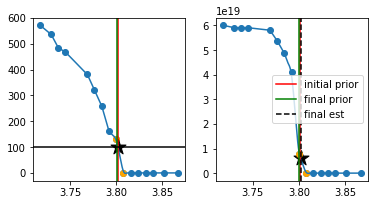

5.951507457325924e+18


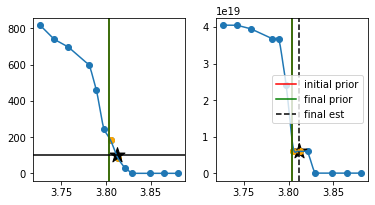

1.452722575215499e+18


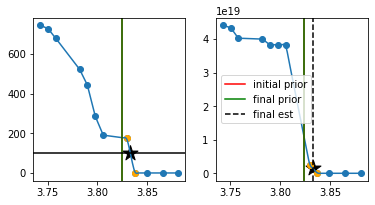

4.907654636224791e+18


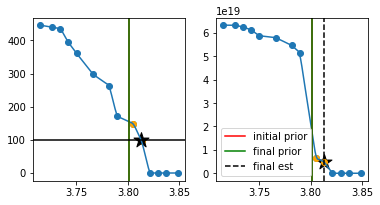

3.963941274574026e+18


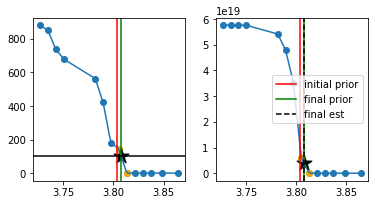

3.957893398009146e+18


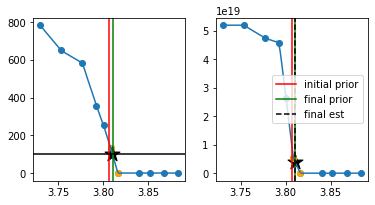

3.6744399759875825e+18


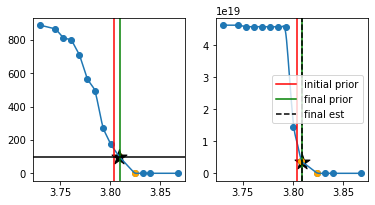

4.717172129314026e+18


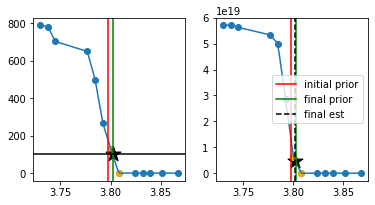

2.98854759519261e+18


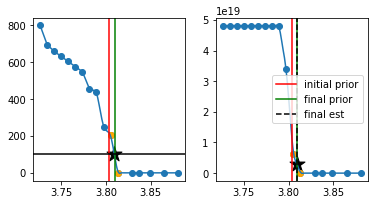

4.1347110089122596e+18


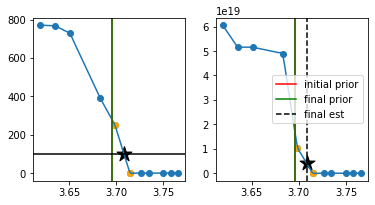

4.743388133630872e+18


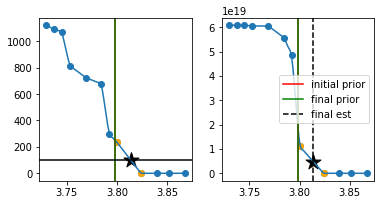

5.891208040635432e+18


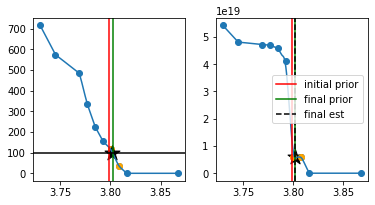

5.819883820853232e+18


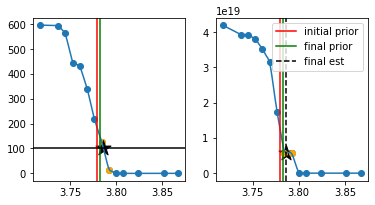

5.299009705198033e+18


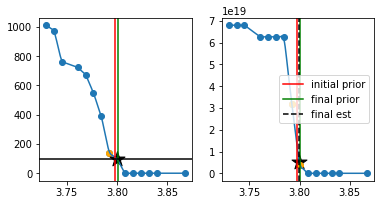

3.4868946323188506e+18


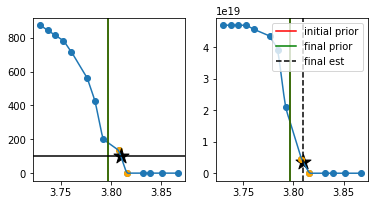

3.2959991346364416e+18


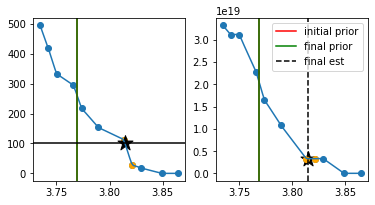

4.653103744687097e+18


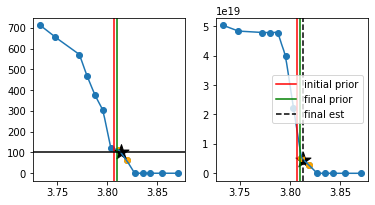

3.8517156216519496e+18


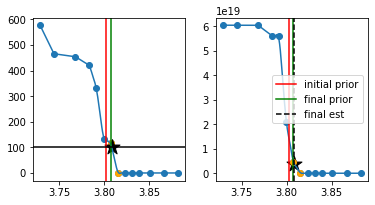

5.270209830131455e+18


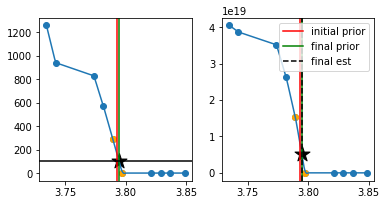

3.670727884466726e+18


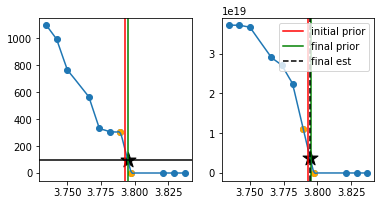

5.483580462201757e+18


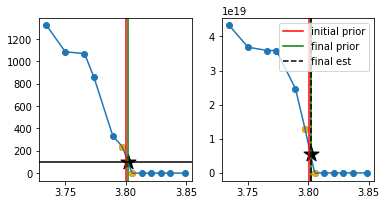

5.961789759656321e+18


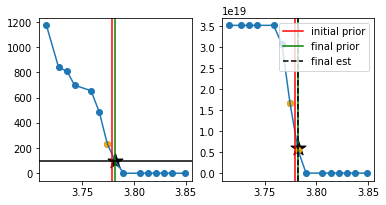

4.952069325905744e+18


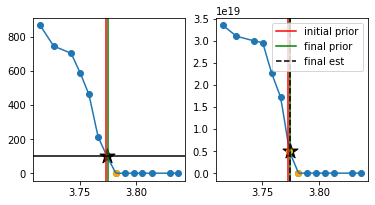

3.905102606538052e+18


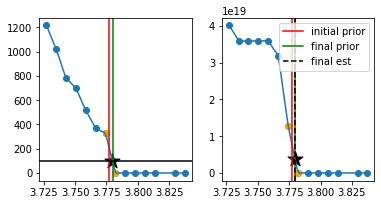

2.95600704768103e+18


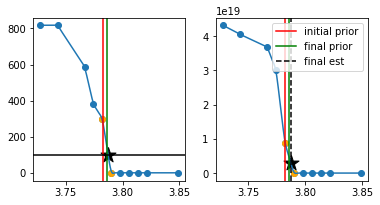

5.361660353871376e+18


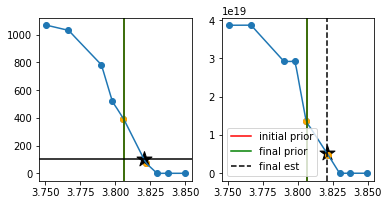

5.141994144466538e+18


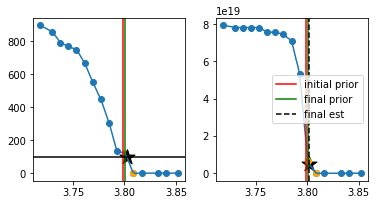

3.1187698522437427e+18


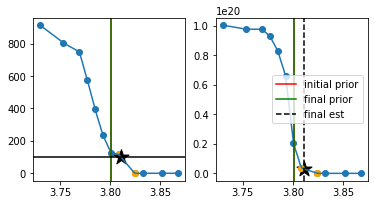

In [134]:
def pedestal_top(p, x, plot_result=False):
    # standardize signal
    p = standardize_signal(p, trim_zeros=True)

    # interp signal to Nx=50
    f_interp = interpolate.interp1d(x, p)
    x_h = np.linspace(x[0], x[-1], 50)  # interpolate to 50 (evenly spaced) points
    p_h = f_interp(x_h)

    # smooth with savgol filter
    p_s = savgol_filter(p_h, window_length=11, polyorder=3)

    # get max gradient so we're in the pedestal
    p_s_grad = np.gradient(p_s)
    min_i = np.argmin(p_s_grad)


    # search from pedestal region outward in 2nd derivatives
    p_s_grad2 = np.gradient(p_s_grad)
    p_s_grad2 = savgol_filter(p_s_grad2, window_length=11, polyorder=3)  # aggressively smooth as well
    p_s_grad2 = standardize_signal(p_s_grad2, trim_zeros=True)
    # standardize s.t. if we go >1 sd up/down, we stop searching

    # go to the left from middle point
    sd_cutoff = -.5
    start_cut_early = False  # if we go < -1 for x'', mark as such, such that if we go > -1 again we stop looking
    min_val = p_s_grad2[min_i]
    top_i = min_i
    for i in reversed(range(0, min_i)):
        if p_s_grad2[i] < min_val:
            min_val = p_s_grad2[i]
            top_i = i
            if min_val < sd_cutoff:
                start_cut_early = True
        elif start_cut_early and p_s_grad2[i] > sd_cutoff:
            break

    # found our x for top
    # same procedure for bottom
    sd_cutoff = .5
    start_cut_early = False  # if we go > 1 for x'', etc.
    max_val = p_s_grad2[min_i]
    bottom_i = min_i

    for i in range(min_i+1, x_h.shape[0]):
        if p_s_grad2[i] > max_val:
            max_val = p_s_grad2[i]
            bottom_i = i
            if max_val > sd_cutoff:
                start_cut_early = True
        elif start_cut_early and p_s_grad2[i] < sd_cutoff:
            break

    top, bottom = x_h[top_i], x_h[bottom_i]

    if plot_result:
        plt.plot(x_h, p_s)
        plt.axvline(top, color='red', label='estimated top')
        plt.axvline(bottom, color='blue', label='estimated bottom')
        plt.legend()
        plt.show()
    return top, bottom

def find_separatrix(ne, te, x, plot_result=False):
    top_x, bottom_x = pedestal_top(ne, x, plot_result=False)
    
    # initial estimate
    x_sep = (1/4) * top_x + (3/4) * bottom_x
    x_initial = x_sep
    # scan area around x_sep
    # first, interp to higher space
    x_h = np.linspace(x[0], x[-1], 200)  # interpolate to 50 (evenly spaced) points
    
    f_ne_interp = interpolate.interp1d(x, ne)
    ne_h = f_ne_interp(x_h)
    ne_s = savgol_filter(ne_h, window_length=11, polyorder=3)
    f_te_interp = interpolate.interp1d(x, te)
    te_h = f_te_interp(x_h)
    te_s = savgol_filter(te_h, window_length=11, polyorder=3)
    
    # closest x
    s_i = find_nearest(x_sep, x_h)
    # scan inwards/outwards
    n_step = 10
    te_target = 100 # 100 eV
    te_distr = norm(te_target, 10)  # distribution to weigh new points against
    weight_func = lambda x: x ** 0.05
    
    def te_sep():
        idx = get_nearest_weighted_idx(x_sep, x_h, sort=False)
        val_out = 0
        for w, w_i in idx:
            val_out += w * te_s[w_i]
        return val_out
    
    for i in range(1, n_step+1):
        i_left = s_i - i
        i_right = s_i + i
        if i_left < 0 or i_right > x_h.shape[0] - 1:
            break  # reached outside the grid on 1 side
        weight_pos = i / n_step  # [1/n, 1] adjustment based on how far the value is 'good'
        pdf_l = te_distr.pdf(te_s[i_left])
        adjust_l = weight_pos * pdf_l
        adjust_l = weight_func(adjust_l)
        if te_s[i_left] > te_target and te_sep() < te_target:  # on the left is above 100 --> we need to move left
            x_sep = (x_sep + x_h[i_left] * adjust_l) / (1 + adjust_l)

        pdf_r = te_distr.pdf(te_s[i_right])
        adjust_r = weight_pos * pdf_r
        adjust_r = weight_func(adjust_r)
        if te_s[i_right] < te_target and te_sep() > te_target:  # on the right is below 100 --> we need to move right
            x_sep = (x_sep + x_h[i_right] * adjust_r) / (1 + adjust_r)
    
    # closest_x_index = np.argmin(abs(x_h - x_sep))
    # from_fit = x_h[closest_x_index], te_h[closest_x_index], ne_h[closest_x_index]
    interp_idx_l, interp_idx_r = get_idx_for_linear_interp(x_sep, x, te)
    weights_r, weights_l = get_weights(te, interp_idx_l, interp_idx_r)
    tesep_estimation = weights_l*te[interp_idx_l] + weights_r*te[interp_idx_r]
    nesep_estimation = weights_l*ne[interp_idx_l] + weights_r*ne[interp_idx_r]
    rsep_estimation = weights_l*x[interp_idx_l] + weights_r*x[interp_idx_r]
    if nesep_estimation < 0: 
        plot_result = True
    if plot_result:
        fig, axs=plt.subplots(1, 2, figsize=(6,3))
        axs[0].plot(x_h, te_s)
        axs[0].scatter(x, te)
        axs[0].scatter(x[interp_idx_l], te[interp_idx_l], color='orange')
        axs[0].scatter(x[interp_idx_r], te[interp_idx_r], color='orange')
        
        axs[0].axvline(x_initial, color='red', label='initial estimate')
        axs[0].axvline(x_sep, color='green', label='final estimate')
        axs[0].axhline(100, color='black', label='100eV')
        axs[0].scatter(rsep_estimation, tesep_estimation, color='black',marker='*', s=250)

        axs[1].plot(x_h, ne_s)
        axs[1].scatter(x, ne)
        axs[1].scatter(rsep_estimation, nesep_estimation, color='black',marker='*', s=250)
        axs[1].axvline(x_initial, color='red', label='initial prior')
        axs[1].axvline(x_sep, color='green', label='final prior')
        axs[1].axvline(rsep_estimation, color='black', ls='--', label='final est')
        axs[1].scatter(x[interp_idx_l], ne[interp_idx_l], color='orange')
        axs[1].scatter(x[interp_idx_r], ne[interp_idx_r], color='orange')
        axs[1].legend()
        
        plt.show()
    
    return tesep_estimation, nesep_estimation, rsep_estimation

def get_idx_for_linear_interp(x_sep, x, te): 
    closest_point = np.argmin(abs(x - x_sep))
    if (te < 100).sum() == 0: 
        closest_point = np.argmin(abs(te - 100))
        idx_r = closest_point
        idx_l = idx_r - 1
   
    elif te[closest_point] < 100: 
        idx_r = closest_point
        idx_l = closest_point - 1
        while te[idx_l] < 100: 
            idx_r = idx_l
            idx_l = idx_l - 1
    else: 
        idx_r = closest_point + 1
        idx_l = closest_point
        while te[idx_r] > 100:
            idx_l = idx_r
            idx_r = idx_l + 1
            
    return idx_l, idx_r 
def find_elm_percent(pulse_num, time): 
    try: 
        pulse_elm_timings_frass = np.array(JET_ELM_TIMINGS[pulse_num])
    except KeyError as e:
        return np.nan
    diff = pulse_elm_timings_frass - time
    try:
        time_last_elm = pulse_elm_timings_frass[diff < 0][-1]
        time_next_elm = pulse_elm_timings_frass[diff > 0][0]
        elm_percent = (time - time_last_elm) / (time_next_elm - time_last_elm)
    except IndexError as e:
        elm_percent = np.nan
    return elm_percent
def get_weights(te, idx_l, idx_r, query=100): 
    dist = te[idx_r] - query + query - te[idx_l]
    weights = (1-(te[idx_r] - query)/dist, 1-(query - te[idx_l])/dist) 
    return weights
def get_lorenzo_pred(pulse_num, pulse_time): 
    JPDB_pulse = PULSE_DF_SANDBOX[PULSE_DF_SANDBOX['shot'] == pulse_num]
    if len(JPDB_pulse) > 1: 
        print(JPDB_pulse[['t1', 't2']])
        for local_pulse in JPDB_pulse: 
            t1, t2 = local_pulse[['t1', 't2']]
            if t1 < pulse_time and t2 > pulse_time: 
                nesep_exp, nesep_lor = local_pulse[['neseparatrixfromexpdata10^19(m^-3)', 'neseparatrixfromfit10^19(m^-3)']].values[0]
            else: 
                continue
    else: 
        index_to_take_from = 0
        nesep_exp, nesep_lor = JPDB_pulse[['neseparatrixfromexpdata10^19(m^-3)', 'neseparatrixfromfit10^19(m^-3)']].values[0]
        
    return nesep_exp, nesep_lor
      
# grab example data

# profiles, mps, masks, psis, rmids, trainids, uncerts

our_vals, lor_vals = [], []
for idx in range(0, 5010):
    name = ids[idx]
    pulse_num, time = name.split('/')
    _, lor_val = get_lorenzo_pred(int(pulse_num), time)
    original = profiles[idx][0], profiles[idx][1],uncerts[idx][0], uncerts[idx][1], rmids[idx]
    ne, te, dne, dte, x = original
    new_ne, new_te =  np.minimum.accumulate(ne), np.minimum.accumulate(te)
    keep_idx = np.where(new_te == te)
    
    ne, te, dne, dte, x = new_ne[keep_idx], new_te[keep_idx], dne[keep_idx], dte[keep_idx], x[keep_idx]
    # logical_bool_mask = te < 700
    logical_bool_mask = np.logical_and(ne > 0, te > 0)
    logical_bool_mask = np.logical_and(logical_bool_mask, dte > 0)
    logical_bool_mask = np.logical_and(logical_bool_mask, dne > 0)
    logical_bool_mask = np.logical_and(logical_bool_mask, dte < 3000)
    
    # check if te below 100! 
    if (te < 100).sum() == 0: 
        continue
        
    top_x, bottom_x = pedestal_top(ne, x, plot_result=False)
    try: 
        estimations = find_separatrix(ne, te, x, plot_result=False)
    except IndexError as e:
        print('IDX ERROR', name, idx)
        fig, axs=plt.subplots(1, 2, figsize=(6,3))
        axs[0].scatter(x, te)
        
        axs[0].axhline(100, color='black', label='100eV')
        axs[1].scatter(x, ne)
        axs[1].legend()
        
        plt.show()
    else:
        if estimations[1] < 0.6e19: 
            print(estimations[1])
            find_separatrix(ne, te, x, plot_result=True)
        our_vals.append(estimations[1])
        lor_vals.append(lor_val)
    # print(abs(estimations[1]*1e-19 - lor_val))
lor_vals, our_vals = np.array(lor_vals), 1e-19*np.array(our_vals)

neseparatrixfromfit10^19(m^-3)    0.596483
dtype: float64


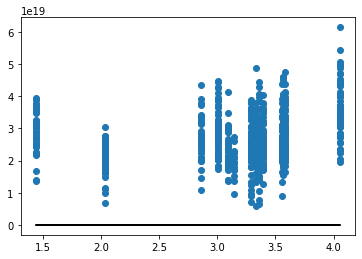

In [132]:
print((PULSE_DF_SANDBOX[['neseparatrixfromfit10^19(m^-3)']]).min())
fig = plt.figure()
cax = plt.scatter(lor_vals, our_vals)
plt.plot(lor_vals, lor_vals, color='black')
plt.show()


In [118]:
from tqdm.notebook import tqdm 

def make_dataset(all_dataset):
    # Store MPS in big table
    # Store Targets (nesep) in array 
    # Store #IDS for lookup later
    profiles, rmids, ids, uncerts, mps = all_dataset 
    iterator = tqdm(range(len(profiles)))
    
    used_mps = []
    used_ids = []
    neseps = []
    used_elm_percents = []
    used_lor_vals = []
    for idx in iterator: 
        name = ids[idx]
        pulse_num, time = name.split('/')
        elm_perc = find_elm_percent(int(pulse_num), float(time))
        if np.isnan(elm_perc): 
            continue
        else: 
            # used_elm_percents.append(elm_perc)
            pass
        _, lor_val = get_lorenzo_pred(int(pulse_num), time)
            
        original = profiles[idx][0], profiles[idx][1],uncerts[idx][0], uncerts[idx][1], rmids[idx]
        find_elm_percent(pulse_num, time)
        ne, te, dne, dte, x = original
        new_ne, new_te =  np.minimum.accumulate(ne), np.minimum.accumulate(te)
        keep_idx = np.where(new_te == te)

        ne, te, dne, dte, x = new_ne[keep_idx], new_te[keep_idx], dne[keep_idx], dte[keep_idx], x[keep_idx]
        logical_bool_mask = np.logical_and(ne > 0, te > 0) # check that nothing is below zero, i mean what the fuck
        logical_bool_mask = np.logical_and(logical_bool_mask, dte > 0) # Also here
        logical_bool_mask = np.logical_and(logical_bool_mask, dne > 0) # Also here 
        logical_bool_mask = np.logical_and(logical_bool_mask, dte < 3000) # Don't want tesep values that are ridonklus
        if (te < 100).sum() == 0:
            continue
        else: 
            try: 
                estimations = find_separatrix(ne, te, x, plot_result=False)
            except IndexError as e:
                print(e)
                continue
            else: 
                neseps.append(estimations[1])
                used_ids.append(name)
                used_mps.append(mps[idx])
                used_elm_percents.append(elm_perc)
                used_lor_vals.append(lor_val)
        
    supervised_dict = {'controls': np.array(used_mps), 'neseps': np.array(neseps), 'ids': used_ids, 'elms': np.array(used_elm_percents), 'lor': np.array(used_lor_vals)} 
    return supervised_dict

supervised_dict = make_dataset(dataset)

  0%|          | 0/31335 [00:00<?, ?it/s]

/tmp/ipykernel_505045/608870348.py:53: RuntimeWarning: divide by zero encountered in true_divide
  return (x - rs.mean()) / rs.standard_deviation()
/tmp/ipykernel_505045/608870348.py:53: RuntimeWarning: invalid value encountered in true_divide
  return (x - rs.mean()) / rs.standard_deviation()
/home/local/kitadam/ENR_Sven/general_ml/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: invalid value encountered in subtract
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/tmp/ipykernel_505045/608870348.py:53: RuntimeWarning: divide by zero encountered in true_divide
  return (x - rs.mean()) / rs.standard_deviation()
/tmp/ipykernel_505045/608870348.py:53: RuntimeWarning: invalid value encountered in true_divide
  return (x - rs.mean()) / rs.standard_deviation()
/home/local/kitadam/ENR_Sven/general_ml/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: invalid value encountered in subtract
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:

In [116]:
with open('../../../moxie/data/processed/supervised_dict_collab_160522.pickle', 'wb') as file: 
    pickle.dump(supervised_dict, file)

In [117]:
print(supervised_dict['elms'].shape, supervised_dict['controls'].shape)

(25007,) (25007, 13)


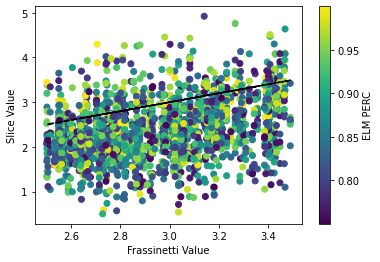

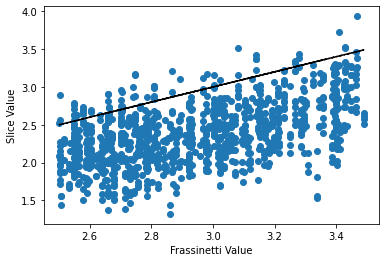

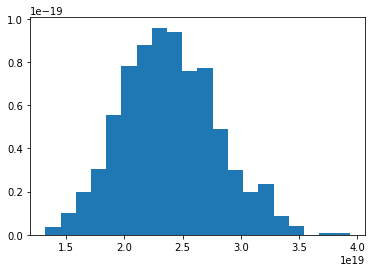

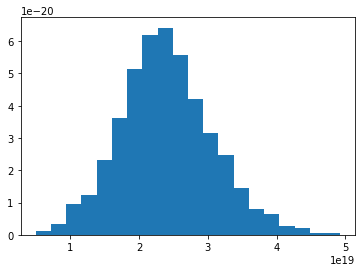

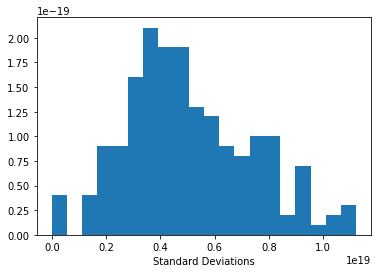

In [183]:
lor, ours, elm, ids = supervised_dict['lor'], supervised_dict['neseps'], supervised_dict['elms'], np.array(supervised_dict['ids'])


fig = plt.figure()
mask = elm > 0.75
mask = np.logical_and(mask, ours > 0.5e19)
mask = np.logical_and(mask, lor > 2.5)
mask = np.logical_and(mask, lor < 3.5)

masked_ids = ids[mask]
masked_lor = lor[mask]
masked_ours = ours[mask]
order = [int(x.split('/')[0]) for x in masked_ids]
pulses = unique(order)
idxs = [[index for index in range(len(order)) if order[index] == pulse] for pulse in pulses]

ours_by_pulse = [np.array([masked_ours[idx] for idx in pulse_idxs]) for pulse_idxs in idxs]
ours_std_by_pulse = [np.array([masked_ours[idx] for idx in pulse_idxs]).std() for pulse_idxs in idxs]
ours_mean_by_pulse = [np.array([masked_ours[idx] for idx in pulse_idxs]).mean() for pulse_idxs in idxs]

lor_by_pulse = [np.array([masked_lor[idx] for idx in pulse_idxs]) for pulse_idxs in idxs]

reduced_ours = []
reduced_lor = []
for n, (sub_pulse, lor_pulse) in enumerate(zip(ours_by_pulse, lor_by_pulse)):
    pulse_std, pulse_mean = ours_std_by_pulse[n], ours_mean_by_pulse[n]
    if pulse_std > 0.5e19: pulse_std = 0.5e19
    for val, val_lor in zip(sub_pulse, lor_pulse): 
        if val > pulse_mean + pulse_std or val < pulse_mean  - pulse_std: 
            continue 
        else: 
            reduced_ours.append(val)
            reduced_lor.append(val_lor)


cax = plt.scatter(lor[mask], 1e-19*ours[mask], c=elm[mask])
plt.plot(lor[mask],lor[mask], color='black', ls='--')
plt.xlabel('Frassinetti Value')
plt.ylabel('Slice Value')
plt.colorbar(cax, label='ELM PERC')
plt.show()


cax = plt.scatter(reduced_lor, 1e-19*np.array(reduced_ours))
plt.plot(reduced_lor,reduced_lor, color='black', ls='--')
plt.xlabel('Frassinetti Value')
plt.ylabel('Slice Value')
# plt.colorbar(cax, label='ELM PERC')
plt.show()

fig = plt.figure()
plt.hist(reduced_ours, density=True, bins=20)
plt.show()

fig = plt.figure()
plt.hist(ours[mask], density=True, bins=20)
plt.show()

fig = plt.figure()
plt.hist(ours_std_by_pulse, density=True, bins=20)
plt.xlabel('Standard Deviations')
plt.show()

In [177]:
def unique(sequence):
    seen = set()
    return [x for x in sequence if not (x in seen or seen.add(x))]
